In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

# Initial setup

In [85]:
df = pd.read_csv("data/daily_sales_french_bakery.csv", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


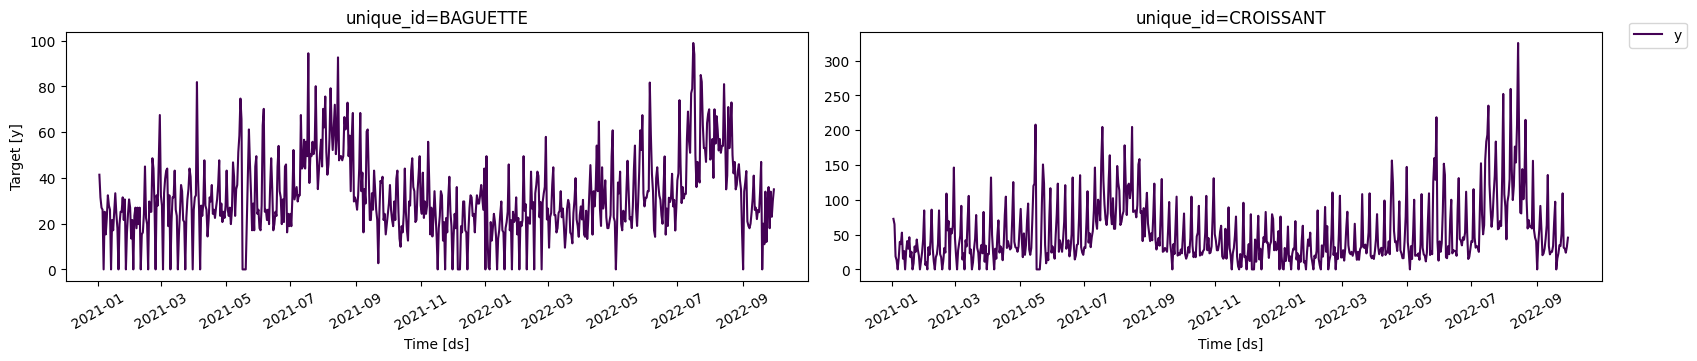

In [86]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], palette="viridis")

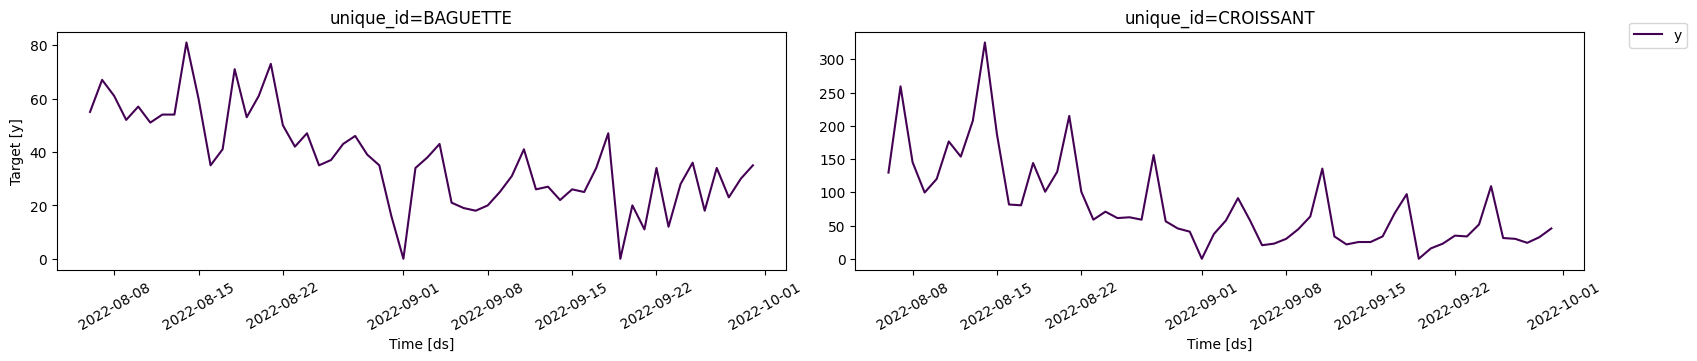

In [87]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

# Baseline Models

In [88]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [89]:
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [90]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


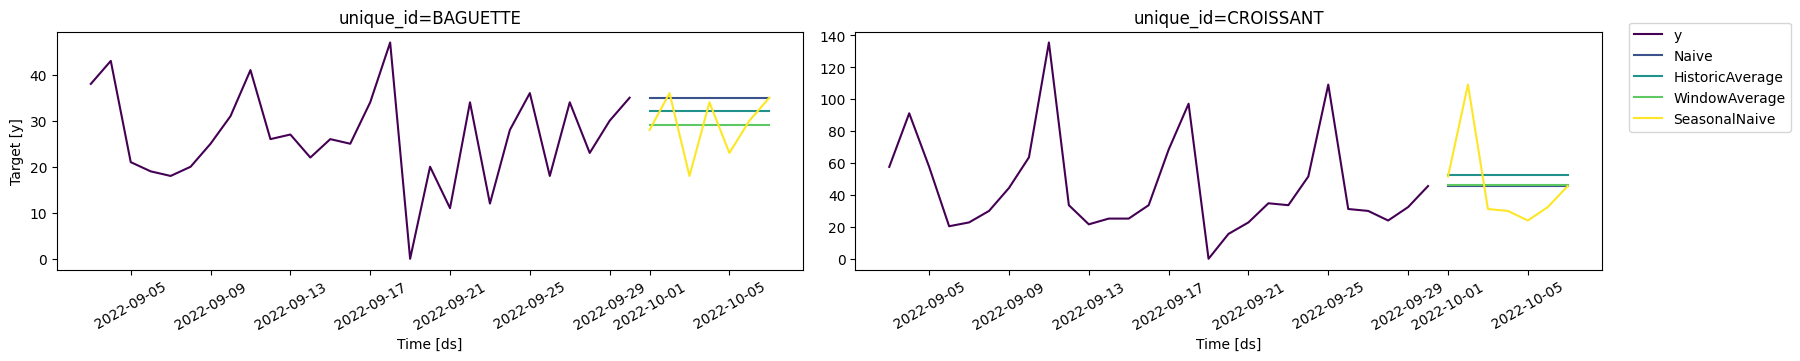

In [91]:
plot_series(
    df=df, 
    forecasts_df=preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28 , 
    palette="viridis")

# Evaluate baseline models

In [92]:
test = df.groupby("unique_id").tail(7) ## 표의 라스트 7일치를 미리 빼놓아서 test데이터로 지정
train = df.drop(test.index).reset_index(drop=True) ## 모든 데이터에서 test데이터를 뺀 데이터를 train으로 지정 
test.head()

,unique_id,ds,y
71,12 MACARON,2022-09-22,0.0
72,12 MACARON,2022-09-23,0.0
73,12 MACARON,2022-09-24,10.0
74,12 MACARON,2022-09-25,0.0
75,12 MACARON,2022-09-26,0.0


In [93]:
sf.fit(df=train) ## train을 모델에 학습
preds = sf.predict(h = horizon) ## 해당 모델이 그 후의 7일만큼의 예측값을 제시
eval_df = pd.merge(test,preds,'left',['ds','unique_id']) ## test와 preds를 병합
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-22,0.0,9.577465,1.428571,10.0
1,12 MACARON,2022-09-23,0.0,9.577465,1.428571,0.0
2,12 MACARON,2022-09-24,0.0,9.577465,1.428571,0.0
3,12 MACARON,2022-09-25,0.0,9.577465,1.428571,0.0
4,12 MACARON,2022-09-26,0.0,9.577465,1.428571,0.0


In [94]:
evaluation = evaluate(
    eval_df,
    metrics=[mae],
) ## 각 모델의 평균 오차를 계산
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [ ]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index() ## 전체 데이터의 평균 계산
evaluation ## 값이 0에 가까울수록 정확도가 높음

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


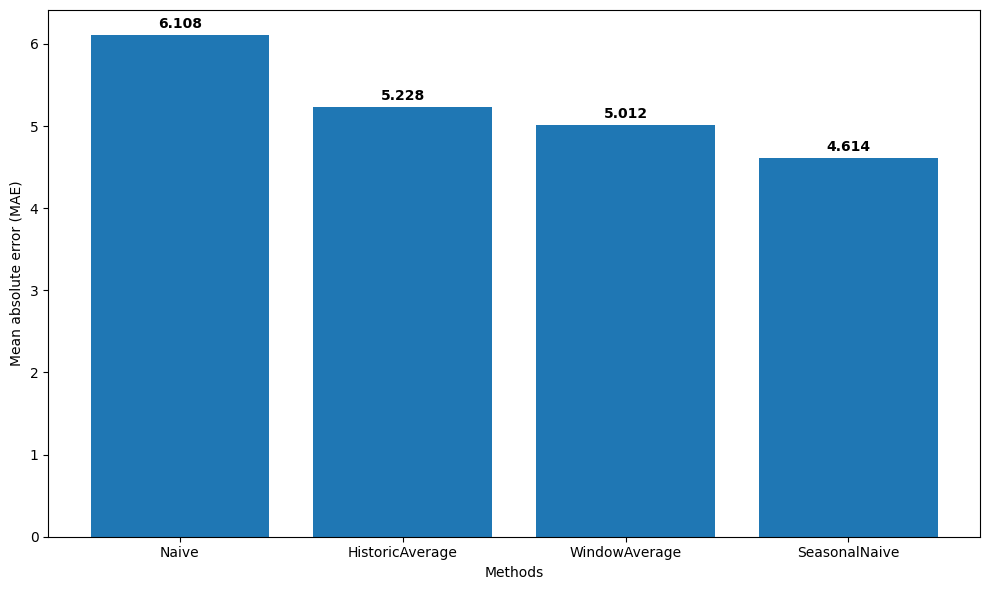

In [96]:
methods = evaluation.columns[1:].tolist()  
values = evaluation.iloc[0, 1:].tolist() 

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()
